# This note book is from
https://www.kaggle.com/code/gallo33henrique/llm-classification-finetuning-ml-lightgbm

In [ ]:
#
!pip install watermark
!pip install transformers datasets torch scikit-learn pandas numpy

In [ ]:
# Import of libraries

# System libraries
import random
import re
import unicodedata
import itertools

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as pl
import plotly.express as px
from matplotlib import pyplot as plt

# Model transformers
import torch
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from keras.preprocessing.sequence import pad_sequences

from IPython.display import display

# Configuration for graph width and layout
sns.set_theme(style="whitegrid")
palette = 'viridis'

import warnings

warnings.filterwarnings("ignore")

# Python version
from platform import python_version

print("Python version in this Jupyter Notebook:", python_version())

# Load library version
import watermark

# Library versions
%reload_ext watermark
%watermark -a 'Library versions' --iversions

In [ ]:
# Carregar o dataset
train_df = pd.read_csv('../../kaggle/input/llm-classification-finetuning/train.csv')
test_df = pd.read_csv('../../kaggle/input/llm-classification-finetuning/test.csv')

In [ ]:
train_df['combined_text'] = train_df['prompt'] + " [SEP] " + train_df['response_a'] + " [SEP] " + train_df['response_b']

test_df['combined_text'] = test_df['prompt'] + " [SEP] " + test_df['response_a'] + " [SEP] " + test_df['response_b']

train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)

train_df.head()

In [ ]:
train_df['label'] = train_df.label.map({v: k for k, v in enumerate(['winner_model_a', 'winner_model_b', 'winner_tie'])})
train_df.head(10)

In [ ]:
# View missing values

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap=palette)
plt.title("Viewing Missing Values in the Training Set")
plt.show()

In [ ]:
print("Number of missing values per column:")
print(train_df.isnull().sum())

In [ ]:
train_df.winner_model_a.value_counts()

In [ ]:
# 3. Distribution of the Target Variable "Class"
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution of Binding Free Energy (BFE)")
plt.grid(False)
plt.show()

In [ ]:
# 1. Basic Characteristics of the Dataset
print("Dataset Information:")
train_df.info()
print()
print("\nSummary Statistics:")
train_df.describe().T

In [ ]:
value_counts2 = train_df['model_a'].value_counts(ascending=True)
# Plotting
fig = px.bar(value_counts2, x=value_counts2.index, y=value_counts2.values, title="Value Counts in Descending Order",
             color=value_counts2.values, color_continuous_scale=palette)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
value_counts2 = train_df['model_b'].value_counts(ascending=True)

fig = px.bar(value_counts2, x=value_counts2.index, y=value_counts2.values, title="Value Counts in Descending Order",
             color=value_counts2.values, color_continuous_scale=palette)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

vectorizer_prompt = TfidfVectorizer(max_features=500)
vectorizer_resp_a = TfidfVectorizer(max_features=500)
vectorizer_resp_b = TfidfVectorizer(max_features=500)

"""
TF-IDF value:
High → word is frequent in this doc but rare in the whole corpus.
Low → word is either rare in this doc, or common across all docs (stopwords).
"""

train_prompt_features = vectorizer_prompt.fit_transform(train_df['prompt'])
train_resp_a_features = vectorizer_resp_a.fit_transform(train_df['response_a'])
train_resp_b_features = vectorizer_resp_b.fit_transform(train_df['response_b'])

train_combined_features = hstack([train_prompt_features, train_resp_a_features, train_resp_b_features])

test_prompt_features = vectorizer_prompt.transform(test_df['prompt'])
test_resp_a_features = vectorizer_resp_a.transform(test_df['response_a'])
test_resp_b_features = vectorizer_resp_b.transform(test_df['response_b'])

test_combined_features = hstack([test_prompt_features, test_resp_a_features, test_resp_b_features])

final_test_features = test_combined_features

final_train_features = train_combined_features

In [ ]:
from sklearn.model_selection import train_test_split

X = final_train_features
y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']]

X_train, X_val, y_train, y_val = train_test_split(X, train_df['label'],
                                                  test_size=0.2, random_state=42,
                                                  stratify=train_df['label'])

# Viewing training data
print("Viewing rows and columns given by X train", X_train.shape)

# Viewing test data
print("Viewing rows and columns given y train", y_train.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [74]:
from lightgbm import LGBMClassifier

lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': -1,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': np.unique(y_train),
    'device': 'cpu',
    'random_state': 42,
    'verbose': -1
}

model = LGBMClassifier(**lgbm_params)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351844
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1499
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [75]:
test = test_combined_features

In [78]:
y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)

val_predictions_df = pd.DataFrame({
    'prediction_val': y_pred_val,
    'proba_0_val': y_proba_val[:, 0],
    'proba_1_val': y_proba_val[:, 1],
    'proba_2_val': y_proba_val[:, 2],
})

y_pred_test = model.predict(test)
y_proba_test = model.predict_proba(test)

test_predictions_df = pd.DataFrame({
    'prediction_test': y_pred_test,
    'proba_0_test': y_proba_test[:, 0],
    'proba_1_test': y_proba_test[:, 1],
    'proba_2_test': y_proba_test[:, 2],
})

In [79]:
combined_df = pd.concat([train_df, val_predictions_df, test_predictions_df], axis=1)

combined_df.head(n=10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,combined_text,label,prediction_val,proba_0_val,proba_1_val,proba_2_val,prediction_test,proba_0_test,proba_1_test,proba_2_test
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[""Is it morally right to try to have a certain...",0,0.0,0.387939,0.228758,0.383304,2.0,0.185942,0.275962,0.538095
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,"[""What is the difference between marriage lice...",1,0.0,0.429364,0.312509,0.258127,2.0,0.347148,0.225333,0.427519
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,"[""explain function calling. how would you call...",2,0.0,0.444209,0.269750,0.286040,1.0,0.267783,0.449979,0.282239
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,"[""How can I create a test set for a very rare ...",0,1.0,0.259499,0.480761,0.259739,NaN,NaN,NaN,NaN
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,"[""What is the best way to travel from Tel-Aviv...",1,2.0,0.274043,0.223973,0.501984,NaN,NaN,NaN,NaN
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,"[""Construct a rap battle, in the style of Epic...",1,0.0,0.493912,0.352968,0.153121,NaN,NaN,NaN,NaN
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,"[""Why water is not used in bath tub?""] [SEP] [...",0,0.0,0.654321,0.184370,0.161309,NaN,NaN,NaN,NaN
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,"[""\""Bacteria is life on Mars but a heartbeat i...",1,2.0,0.289058,0.201611,0.509331,NaN,NaN,NaN,NaN
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,"[""translate to russian the followig sentence ...",1,1.0,0.260162,0.426685,0.313153,NaN,NaN,NaN,NaN
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,"[""From now, you *always* have to talk as if yo...",1,0.0,0.482069,0.328317,0.189614,NaN,NaN,NaN,NaN


In [80]:
data_llm = combined_df[["model_a", "prediction_val", "proba_0_val"]]
data_llm.head(n=10)

,model_a,prediction_val,proba_0_val
0,gpt-4-1106-preview,0.0,0.387939
1,koala-13b,0.0,0.429364
2,gpt-3.5-turbo-0613,0.0,0.444209
3,llama-2-13b-chat,1.0,0.259499
4,koala-13b,2.0,0.274043
5,vicuna-13b,0.0,0.493912
6,mixtral-8x7b-instruct-v0.1,0.0,0.654321
7,gemini-pro,2.0,0.289058
8,gpt-3.5-turbo-0613,1.0,0.260162
9,gpt-4-0314,0.0,0.482069


In [87]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# AUC-ROC
if len(np.unique(y_val)) > 2:  # Multiclasse
    # Binarizar os rótulos para calcular AUC-ROC
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)  # Rótulos binarizados
    auc_roc = roc_auc_score(y_val_binarized, y_proba_val, multi_class='ovr')
    auc_roc_2 = roc_auc_score(y_val, y_proba_val, multi_class='ovr')
    print(f"AUC-ROC (Multiclasse - OVR): {auc_roc:.4f}")
else:  # Binário
    auc_roc = roc_auc_score(y_val, y_proba_val[:, 1])
    print(f"AUC-ROC (Binário): {auc_roc:.4f}")

AUC-ROC (Multiclasse - OVR): 0.6331  0.6331


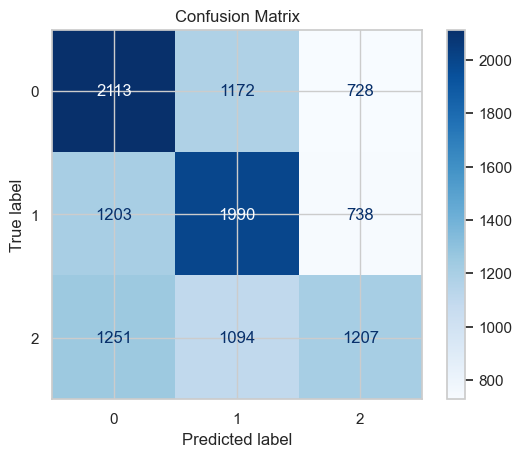

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_val, labels=np.unique(y_val))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues, values_format="d")

plt.title("Confusion Matrix")
plt.show()

In [90]:
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy}')

Accuracy: 0.4618997912317328


In [91]:
report = classification_report(y_val, y_pred_val)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49      4013
           1       0.47      0.51      0.49      3931
           2       0.45      0.34      0.39      3552

    accuracy                           0.46     11496
   macro avg       0.46      0.46      0.46     11496
weighted avg       0.46      0.46      0.46     11496



In [111]:
y_test_pred = model.predict_proba(test)
submission = pd.DataFrame({
        'id': test_df['id'],
        'winner_model_a': y_test_pred[:, 0],
        'winner_model_b': y_test_pred[:, 1],
        'winner_tie': y_test_pred[:, 2]
    })

submission.to_csv('predictions_LGBMClassifier.csv', index=False)